In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import re

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

For this project we are using the [US Accidents](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) dataset from Kaggle. This dataset contains data of traffic accidents that occured in the US from 2016 to 2023 so we will filter it to only work with data for cities the most similar to Montreal, QC.

### Load dataset

In [3]:
us_data = pd.read_csv("data/US_Accidents_March23.csv")
us_data.shape

(7728394, 46)

### Filtering dataset
Similar to Montreal, some U.S. cities, such as Boston, Minneapolis, and Chicago, share key characteristics like cold winters, urban density, and reliance on public transportation. These cities experience harsh weather conditions that affect road safety, leading to higher accident rates during winter, much like Montreal. They also have dense urban areas with mixed traffic from cars and public transit, creating complex traffic patterns. Additionally, cities like Pittsburgh and Seattle face geographic challenges that further impact road infrastructure, making them comparable to Montreal in traffic and accident dynamics.

In [4]:
similar_cities = ["Philadelphia, PA", "Minneapolis, MN", "Chicago, IL", "	Pittsburgh, PA", "Buffalo, NY", "Cleveland, OH", 
                  "Seattle, WA", "Detroit, MI", "Milwaukee, WI", "Rochester, NY", "Denver, CO", "Albany, NY", "Portland, ME"]

In [5]:
filtered_data = us_data[(us_data["City"] + ", " + us_data["State"]).isin(similar_cities)]
filtered_data.shape

(260269, 46)

In [6]:
df_clean = filtered_data.copy()
del(filtered_data)

### Drop redundant or irrelevant columns

In [7]:
initial_size = len(df_clean)

In [8]:
df_clean = df_clean.drop(columns=["Country", "Source", "End_Lat", "End_Lng", "Description", "Airport_Code", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight",
                                 "Wind_Direction", "Wind_Chill(F)", "Timezone", "Weather_Timestamp", "Zipcode"])

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260269 entries, 87 to 7728271
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 260269 non-null  object 
 1   Severity           260269 non-null  int64  
 2   Start_Time         260269 non-null  object 
 3   End_Time           260269 non-null  object 
 4   Start_Lat          260269 non-null  float64
 5   Start_Lng          260269 non-null  float64
 6   Distance(mi)       260269 non-null  float64
 7   Street             260125 non-null  object 
 8   City               260269 non-null  object 
 9   County             260269 non-null  object 
 10  State              260269 non-null  object 
 11  Temperature(F)     259742 non-null  float64
 12  Humidity(%)        259497 non-null  float64
 13  Pressure(in)       259860 non-null  float64
 14  Visibility(mi)     259779 non-null  float64
 15  Wind_Speed(mph)    249672 non-null  float64
 16  

### Fix data types

In [10]:
df_clean["Start_Time"] = pd.to_datetime(df_clean["Start_Time"])
df_clean["End_Time"] = pd.to_datetime(df_clean["End_Time"])

### Remove duplicates
There are 3,817 (1.56%) duplicated accidents in the dataset.

In [11]:
df_clean.drop(columns=["ID"]).duplicated().sum() / len(df_clean)

0.016901743964897856

In [12]:
df_clean = df_clean.drop(columns=["ID"]).drop_duplicates()

### Handle missing values?

In [13]:
missing_values = df_clean.isnull().sum()
missing_values = missing_values[missing_values > 0]
# Print percentage of missing values per column
100 * missing_values / df_clean.shape[0]

Street                0.055888
Temperature(F)        0.196975
Humidity(%)           0.291554
Pressure(in)          0.151640
Visibility(mi)        0.182515
Wind_Speed(mph)       4.121233
Precipitation(in)    30.911791
Weather_Condition     0.174698
dtype: float64

Many columns are missing a very small amount of data (< 1%), hence we could remove the rows with missing values. Meanwhile, in the case of other columns such as `Precipitation` and `Wind_Speed(mph)` as missing value could mean there were no precipitation or nearly still wind, respectively.

In [14]:
# Drop rows with missing values
df_clean = df_clean.dropna(subset=["Street", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Weather_Condition"])

In [15]:
# Fill missing values
df_clean["Wind_Speed(mph)"] = df_clean["Wind_Speed(mph)"].fillna(0.0)
df_clean["Precipitation(in)"] = df_clean["Precipitation(in)"].fillna(0.0)

In [16]:
df_clean.isnull().sum()

Severity             0
Start_Time           0
End_Time             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Street               0
City                 0
County               0
State                0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
dtype: int64

### Creating new columns

Street names by themselves may have too many values to work with but could extract the road type (`Is_Highway`) from the names.

In [17]:
def is_highway(street_name):
    # Check if the street name contains common highway prefixes or suffixes
    highway_prefixes = ['I-', 'US-', 'SR-', 'HWY', 'INTERSTATE', 'US HIGHWAY', 'STATE ROUTE']
    highway_suffixes = ['INTERSTATE', 'HIGHWAY', 'EXPRESSWAY', 'TURNPIKE', 'PARKWAY', 'ROUTE']
    for prefix in highway_prefixes:
        if street_name.upper().startswith(prefix):
            return True
    for suffix in highway_suffixes:
        if street_name.upper().endswith(suffix):
            return True
    return False

In [18]:
df_clean["Is_Highway"] = df_clean["Street"].apply(is_highway)

We can also compute the duration of the accident as the difference between `End_Time` and `Start_Time`.

In [19]:
df_clean["Duration(min)"] = (df_clean["End_Time"] - df_clean["Start_Time"]).dt.total_seconds() / 60

We can also extract time-related information from Start_Time

In [20]:
# Date of the accident
df_clean["Date"] = pd.to_datetime(df_clean["Start_Time"].dt.date)
# Time of the accident
df_clean["Hour"] = df_clean["Start_Time"].dt.hour
# Day of the week when the accident occured
df_clean["Day_of_Week"] = df_clean["Start_Time"].dt.dayofweek + 1  # index for day of the week start at 0
df_clean["Is_Weekend"] = df_clean["Day_of_Week"] >= 6
# Month of the accident
df_clean["Month"] = df_clean["Start_Time"].dt.month
# Year of the accident
df_clean["Year"] = df_clean["Start_Time"].dt.year

In [21]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Invalid month"

In [22]:
#df_clean["Season"] = df_clean["Month"].apply(get_season)

In addition, `Sunrise_Sunset` can be used to determine if it was day of night.

In [23]:
df_clean["Sunrise_Sunset"].unique()

array(['Night', 'Day'], dtype=object)

In [24]:
df_clean["Is_Night"] = df_clean["Sunrise_Sunset"] == "Night"

We have a lot of different type of weather conditions formulated in different manners. We could categorize them.

In [25]:
def categorize_weather(condition):
    dry_regex = "clear|fair|sunny|overcast|cloud|haze|patches of fog"
    wet_regex = "rain|drizzle|shower|storm|thunder|sleet|wintry mix"
    snow_regex = "snow"
    if re.search(dry_regex, condition.lower()):
        return "Dry Weather"
    if re.search(wet_regex, condition.lower()):
        return "Wet Weather"
    if re.search(snow_regex, condition.lower()):
        return "Snow"
    return "Other"

In [26]:
def categorize_weather_regex(condition):
    # Define the categories and their regex patterns
    weather_categories = {
        'Clear': r'(clear|fair|sunny)',
        'Cloudy': r'(overcast|mostly cloudy|partly cloudy|scattered clouds|cloudy)',
        'Reduced Visibility': r'(fog|mist|haze|shallow fog|patches of fog|partial fog|smoke)',
        'Rain': r'(rain|light rain|drizzle|light drizzle|heavy rain|showers)',
        'Extreme/Stormy Weather': r'(squalls|funnel cloud|thunderstorms and snow|tornado|thunder|thunderstorm|t-storm|storm)',
        'Winter Weather': r'(snow|blowing snow|snow shower|snow and sleet|freezing rain|sleet|ice pellets)',
    }
    
    # Match the condition against the regex patterns
    for category, pattern in weather_categories.items():
        if re.search(pattern, condition, re.IGNORECASE):
            return category
    return 'Other/Unknown'


In [27]:
df_clean["Weather_Condition"] = df_clean["Weather_Condition"].apply(lambda condition: categorize_weather_regex(condition))

In [28]:
df_clean["Weather_Condition"].value_counts()

Cloudy                    140831
Clear                      68163
Rain                       21833
Winter Weather             17795
Reduced Visibility          4374
Other/Unknown                923
Extreme/Stormy Weather       821
Name: Weather_Condition, dtype: int64

### Fixing numeric inconsistencies and removing outliers
Some of the values in the dataset appear unrealistic or highly improbable based on historical data from cities similar to Montreal, particularly in the context of traffic accidents. For instance:
* The maximum value of 254.4 miles is excessively high for a single traffic accident’s impact. Typically, accidents would affect a much smaller road segment (5-10miles or up to 30miles on highways).
* The minimum of -29°F is plausible in the colder cities like Minneapolis or Buffalo. However, the maximum of 189°F is far beyond normal environmental conditions.
* The range of 16.82 inHg to 31.14 inHg is quite unusual for atmospheric pressure. Standard atmospheric pressure generally ranges from 28 inHg to 31 inHg.
* A maximum visibility of 90 miles seems unrealistic, especially in urban environments with buildings, weather, and air quality affecting visibility. Typical visibility in clear weather would be about 10-20 miles.
* The maximum wind speed of 254.3 mph is far too high, likely indicating an error, as this exceeds hurricane-force winds. Typical wind speeds in urban areas range from 0 to 40 mph, with severe storms sometimes reaching 60-70 mph.
* The maximum duration of 1,144,140 minutes (~795 days) is clearly unrealistic. A typical range would be from 1 minute to 300 minutes (5 hours), with severe incidents sometimes lasting longer.

In [29]:
anomalities_cols = ['Distance(mi)', 'Temperature(F)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Duration(min)']

In [30]:
# Function to calculate 95% confidence interval excluding outliers
def iqr_interval(data, confidence=0.95):
    # Calculate IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (lower_bound, upper_bound)

In [31]:
def plot_cols_with_anomalies(df):
    # Set up subplots
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    axes = axes.flatten()
    # Create a box plot for each column
    for i, col in enumerate(anomalities_cols):
        #sns.boxplot(data=df_clean, x=col, ax=axes[i])
        sns.boxplot(data=df, x=col, ax=axes[i])
        # Add text for confidence intervals
        mean_val = np.mean(df[col])
        iqr_low, iqr_high = iqr_interval(df_clean[col].dropna())
        ci_text = f'IQR Spread: [{iqr_low:.2f}, {iqr_high:.2f}]' if not iqr_low == iqr_high else 'No valid data'
        axes[i].text(0.5, -0.5, ci_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)
        # Add title
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

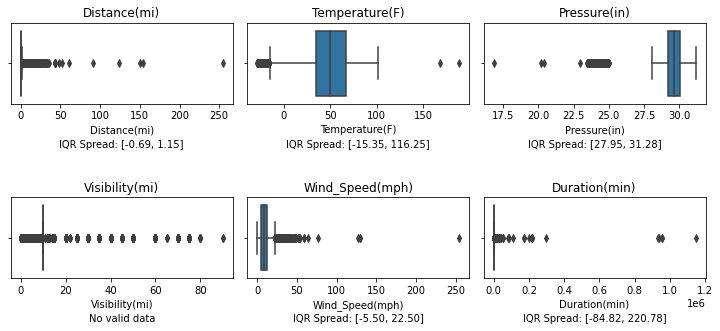

In [32]:
plot_cols_with_anomalies(df_clean)

Lets first remove the highly abnormal values:
* Distances of over 30 miles.
* Temperatures over 115.35.
* Pressure below 25.69 inHg (October 12, 1979 in the eye of Typhoon Tip).
* Visibility greater than 20 miles.
* Windspeed of over 40mph.
* Accident duration of over 24 hours (1440 min).

In [33]:
adjusted_ranges = ((df_clean["Distance(mi)"] <= 30) \
& (df_clean["Temperature(F)"] <= 115.35) \
& (df_clean["Pressure(in)"] >= 25.69) \
& (df_clean["Visibility(mi)"] <= 20) \
& (df_clean["Wind_Speed(mph)"] <= 40) \
& (df_clean["Duration(min)"] <= 1440))

In [34]:
df_clean = df_clean[adjusted_ranges]

After dropping rows with abnormal values, we lose about 10% of the data. Combined with all of the previous data cleaning steps, we are left with about 89% of the original filtered data.

In [35]:
len(df_clean) / initial_size

0.8940250279518498

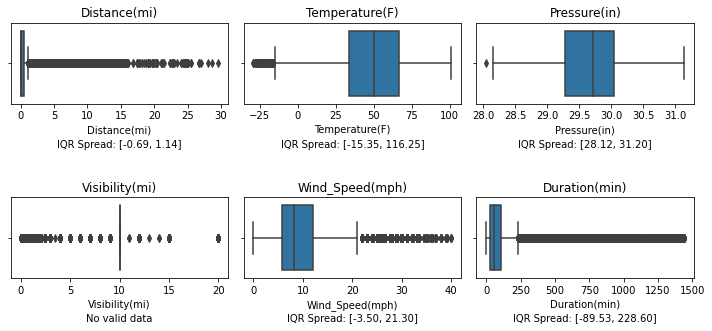

In [36]:
plot_cols_with_anomalies(df_clean)

### Save dataset

In [37]:
df_clean.shape

(232687, 40)

In [38]:
df_clean["Severity"].value_counts().sort_index()

1      1341
2    153652
3     73403
4      4291
Name: Severity, dtype: int64

In [39]:
df_clean["Year"].value_counts().sort_index()

2016    13484
2017    30752
2018    39076
2019    35510
2020    33299
2021    36139
2022    37365
2023     7062
Name: Year, dtype: int64

In [40]:
df_clean.to_csv("data/data_clean.csv", index=False)